In [2]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, BertTokenizer, BertModel
from datasets import Dataset, load_from_disk
import evaluate
import torch

import numpy as np
import pandas as pd
import re
import scipy

import matplotlib.pyplot as plt
import json

from tqdm import tqdm
from rapidfuzz.distance import Levenshtein, Opcodes

In [ ]:
SAMPLING_RATE = 16_000

In [ ]:
T5_MODEL_NAME = "/home/sulcm/models/t5/t5-spellchecker-cs-v20"

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
dataset = load_from_disk("/home/sulcm/datasets/t5/asr-correction-cs-v23/test")
# dataset = load_from_disk("/home/sulcm/datasets/t5/asr-correction-commonvoice-test-cs-v23/test")

In [ ]:
dataset

# Create and compute eval data

In [ ]:
wer_metric = evaluate.load("wer")

In [ ]:
prefix = "spell check: "
t5_tokenizer = T5Tokenizer.from_pretrained(T5_MODEL_NAME)
t5_model = T5ForConditionalGeneration.from_pretrained(T5_MODEL_NAME).to(device)

In [ ]:
t5_correction_and_results = {
    "t5_correction": [],
    "w2v2_vs_target_wer": [],
    "t5_vs_target_wer": [],
    "w2v2_vs_t5_wer": []
}

for ds_row in tqdm(dataset):
    # asr_transcription, target_output
    inputs = t5_tokenizer(prefix + ds_row["asr_transcription"], return_tensors="pt").to(device)
    output_sequences = t5_model.generate(**inputs, max_new_tokens=64, num_beams=4, do_sample=True)
    corrected_input = t5_tokenizer.batch_decode(output_sequences, skip_special_tokens=True)

    t5_correction_and_results["w2v2_vs_target_wer"].append(wer_metric.compute(predictions=(ds_row["asr_transcription"],), references=(ds_row["target_output"],)))
    t5_correction_and_results["t5_vs_target_wer"].append(wer_metric.compute(predictions=corrected_input, references=(ds_row["target_output"],)))
    t5_correction_and_results["w2v2_vs_t5_wer"].append(wer_metric.compute(predictions=(ds_row["asr_transcription"],), references=corrected_input))
    t5_correction_and_results["t5_correction"].extend(corrected_input)

In [ ]:
# with open("./data/error_eval_commonvoice_ds_v23_test_w_t5_v20.json", "w") as f:
#     json.dump(t5_correction_and_results, f)

# Evaluation of results

In [ ]:
with open("./data/error_eval_voxpopuli_ds_v23_test_w_t5_v20.json", "r") as f:
    t5_correction_and_results = json.load(f)

In [ ]:
class ST6ErrorAnalysis():
    def __init__(self, classes_def_path: str="") -> None:
        word_classes_file = {}
        if classes_def_path:
            with open(classes_def_path, "r") as f:
                word_classes_file = json.load(f)

        self.word_classes_by_label = word_classes_file.get("definitions", {})
        self.id2label = word_classes_file.get("classes", [])
        self.label2id = {l: i for i, l in enumerate(self.id2label)}
        
        self.test_methods = [self.is_preposition,
                             self.is_conjunction,
                             self.is_prefix,
                             self.is_iy,
                             self.is_uu,
                             self.is_sz,]

        pass

    def get_error_classes(self, lev_ops: dict) -> list[dict]:
        errors = []
        for action, model_output, reference in zip(lev_ops["action"], lev_ops["model_output"], lev_ops["reference"]):
            match action:
                case "delete":
                    errors.append(self.resolve_error_tests([test_fcn(action, reference) for test_fcn in self.test_methods], reference, action))
                case "insert":
                    errors.append(self.resolve_error_tests([test_fcn(action, model_output) for test_fcn in self.test_methods], model_output, action))
                case "replace":
                    replaced = (model_output[0], reference[0])
                    errors.append(self.resolve_error_tests([test_fcn(action, replaced) for test_fcn in self.test_methods], replaced, action))
        return errors

    def resolve_error_tests(self, tests: list, tested: tuple[str], operation: str) -> dict:
        if any(tests):
            res = [err for err in tests if err is not None]
        elif tested[0] == "" or tested[0] == " ":
            res = []
        else:
            res = ["other"]
        
        space_err = self.check_spaces(operation, tested)
        if space_err:
            res.append(space_err)
        
        return {operation: res}

    def check_spaces(self, operation: str, op: tuple[str]) -> str|None:
        val = op[0]
        context = op[1].split(" ")
        if val == "" and len(context) == 1:
            return "removed_space"
        elif " " in val and len(context) > 1:
            if operation == "delete":
                return "removed_space"
            else:
                return "added_space"
        else:
            return None

    def is_preposition(self, operation: str, op: tuple[str]) -> str|None:
        val = op[0].strip()
        context = op[1].split(" ")
        if val in self.word_classes_by_label["prepositions"] and val in context:
            return "prepositions"
        else:
            return None
    
    def is_conjunction(self, operation: str, op: tuple[str]) -> str|None:
        val = op[0].strip()
        context = op[1].split(" ")
        if val in self.word_classes_by_label["conjunctions"] and val in context:
            return "conjunctions"
        else:
            return None
    
    def is_prefix(self, operation: str, op: tuple[str]) -> str|None:
        val = op[0].strip()
        context = op[1].split(" ")
        if val in self.word_classes_by_label["prefixes"] and any([c.startswith(val) and len(c) > len(val) for c in context]):
            return "prefixes"
        else:
            return None
        
    def is_iy(self, operation: str, op: tuple[str]) -> str|None:
        val = op[0].strip()
        context = op[1].strip()
        if val in self.word_classes_by_label["iy"] and context in self.word_classes_by_label["iy"] and val != context:
            return "iy"
        else:
            return None
    
    def is_uu(self, operation: str, op: tuple[str]) -> str|None:
        val = op[0].strip()
        context = op[1].strip()
        if val in self.word_classes_by_label["uu"] and context in self.word_classes_by_label["uu"] and val != context:
            return "uu"
        else:
            return None
    
    def is_sz(self, operation: str, op: tuple[str]) -> str|None:
        val = op[0].strip()
        context = op[1].strip()
        if val in self.word_classes_by_label["sz"] and context in self.word_classes_by_label["sz"] and val != context:
            return "sz"
        else:
            return None
        
    def analyse_error_classes(self, dataset_idxs: list|set|str, ds_model_output: list, ds_target_output: list, operations: list=["delete", "insert", "replace"], return_raw_pd: bool=False) -> dict[dict]|pd.DataFrame:
        if dataset_idxs == "all":
            dataset_idxs = range(len(ds_target_output))
        if isinstance(dataset_idxs, str):
            raise ValueError('String can not refer to list items. Please provide list/set or string "all" for iterating thru all items.')
        
        err_analysis = []
        for test_idx in dataset_idxs:
            idx = int(test_idx)
            lev_ops = self.levenshtein_ops(model_output=ds_model_output[idx], reference=ds_target_output[idx])
            if return_raw_pd:
                err_analysis.append(self.get_error_classes(lev_ops))
            else:
                err_analysis.extend(self.get_error_classes(lev_ops))
        
        if return_raw_pd:
            return pd.DataFrame.from_records(err_analysis)
        else:
            error_classes_counts = {}
            for op in operations:
                class_counts = dict.fromkeys(self.id2label, 0)
                class_counts.update(pd.DataFrame.from_records(err_analysis)[op].dropna().explode().value_counts().to_dict())
                error_classes_counts[op] = class_counts
            
            return error_classes_counts
    
    def plot_error_analysis(self, err_analysis: dict, title: str=None) -> None:
        fig, axes = plt.subplots(ncols=len(err_analysis))
        fig.set_figwidth(10)
        if title:
            fig.suptitle(title)
        for i, (action, stats) in enumerate(err_analysis.items()):
            axes[i].bar(stats.keys(), stats.values())
            axes[i].tick_params(axis='x', labelrotation=90)
            axes[i].set_title(action)
            axes[i].bar_label(axes[i].containers[0], label_type='edge')
        plt.show()
    
    @staticmethod
    def levenshtein_ops(model_output: str, reference: str) -> dict:
        lev_ops = Levenshtein.editops(reference, model_output)
        lev_ops_dict = {
            "action": [],
            "model_output": [],
            "reference": [],
        }
        for ops in Opcodes.from_editops(lev_ops):
            if ops.tag != "equal":
                lev_ops_dict["action"].append(ops.tag)
                lev_ops_dict["reference"].append((reference[ops.src_start:ops.src_end],
                                            (src_start[-1] if (src_start := reference[:ops.src_start].split(" ")) else "") + 
                                            reference[ops.src_start:ops.src_end] + 
                                            (src_end[0] if (src_end := reference[ops.src_end:].split(" ")) else "")))
                lev_ops_dict["model_output"].append((model_output[ops.dest_start:ops.dest_end], 
                                            (dest_start[-1] if (dest_start := model_output[:ops.dest_start].split(" ")) else "") + 
                                            model_output[ops.dest_start:ops.dest_end] + 
                                            (dest_end[0] if (dest_end := model_output[ops.dest_end:].split(" ")) else "")))
        return lev_ops_dict


st6_error_analysis = ST6ErrorAnalysis("./word_classes_definitions.json")

In [ ]:
def compare_outputs(idx: int) -> None:
    print(
        f"W2V2 Transcription (WER = {t5_correction_and_results['w2v2_vs_target_wer'][idx]:.4f}): " + dataset[idx]['asr_transcription'],
        f"     T5 Correction (WER = {t5_correction_and_results['t5_vs_target_wer'][idx]:.4f}): " + t5_correction_and_results['t5_correction'][idx],
        "                    Target output: " + dataset[idx]['target_output'],
        sep="\n"
    )

In [ ]:
t5_errors_df = st6_error_analysis.analyse_error_classes("all", t5_correction_and_results['t5_correction'], dataset["target_output"], return_raw_pd=True)
t5_errors_df.shape

In [ ]:
t5_errors_df.notnull().sum(axis=1).argmax()

In [ ]:
t5_errors_df.notnull().sum(axis=1).where(lambda x: x > 40).dropna()

In [ ]:
idx = 834
st6_error_analysis.levenshtein_ops(t5_correction_and_results['t5_correction'][idx], dataset[idx]["target_output"])

In [ ]:
lev_ops = st6_error_analysis.levenshtein_ops(t5_correction_and_results['t5_correction'][834], dataset[834]["target_output"])
lev_ops

In [ ]:
compare_outputs(834)

In [ ]:
t5_errors = st6_error_analysis.analyse_error_classes("all", t5_correction_and_results['t5_correction'], dataset["target_output"])

In [ ]:
st6_error_analysis.plot_error_analysis(t5_errors, title="T5 errors on W2V2 output vs target output")

In [ ]:
w2v2_errors_df = st6_error_analysis.analyse_error_classes("all", dataset["asr_transcription"], dataset["target_output"], return_raw_pd=True)
w2v2_errors_df.shape

In [ ]:
w2v2_errors_df.notnull().sum(axis=1).argmax()

In [ ]:
w2v2_errors_df.notnull().sum(axis=1).where(lambda x: x > 40).dropna()

In [ ]:
w2v2_errors = st6_error_analysis.analyse_error_classes("all", dataset["asr_transcription"], dataset["target_output"])

In [ ]:
st6_error_analysis.plot_error_analysis(w2v2_errors, title="W2V2 output vs target output")

# Model errors

## T5 mistakes on ***correct*** W2V2 transcription

In [ ]:
correct_w2v2_transcription = np.argwhere(np.transpose(t5_correction_and_results["w2v2_vs_target_wer"]) == 0.0).flatten()
incorrect_t5_correction = np.argwhere(np.transpose(t5_correction_and_results["t5_vs_target_wer"]) > 0.0).flatten()
correct_asr_transcription_incorect_t5_correction = set(correct_w2v2_transcription).intersection(set(incorrect_t5_correction))
len(correct_asr_transcription_incorect_t5_correction)

## T5 good corrections on ***bad*** W2V2 transcription

In [ ]:
incorrect_w2v2_transcription = np.argwhere(np.transpose(t5_correction_and_results["w2v2_vs_target_wer"]) > 0.0).flatten()
correct_t5_correction = np.argwhere(np.transpose(t5_correction_and_results["t5_vs_target_wer"]) == 0.0).flatten()
correct_t5_correction_on_bad_asr_transcription = set(correct_t5_correction).intersection(set(incorrect_w2v2_transcription))
len(correct_t5_correction_on_bad_asr_transcription)

## Correct ASR and correction

In [ ]:
correct_asr_w_correction = set(correct_w2v2_transcription).intersection(set(correct_t5_correction))
len(correct_asr_w_correction)

## Incorrect ASR and incorrect correction

In [ ]:
incorrect_asr_w_correction = set(incorrect_w2v2_transcription).intersection(set(incorrect_t5_correction))
incorrect_asr_w_correction_idx = list(incorrect_asr_w_correction)
len(incorrect_asr_w_correction)

### Less incorrect ASR (T5 corrected some mistakes)

In [ ]:
less_incorrect_asr_idx = np.argwhere(np.array(t5_correction_and_results["w2v2_vs_target_wer"])[incorrect_asr_w_correction_idx] > np.array(t5_correction_and_results["t5_vs_target_wer"])[incorrect_asr_w_correction_idx]).flatten()
less_incorrect_asr = set(np.array(incorrect_asr_w_correction_idx)[less_incorrect_asr_idx])
len(less_incorrect_asr)

### More incorrect ASR (T5 made more mistakes then repaired) 

In [ ]:
more_incorrect_asr_idx = np.argwhere(np.array(t5_correction_and_results["w2v2_vs_target_wer"])[incorrect_asr_w_correction_idx] < np.array(t5_correction_and_results["t5_vs_target_wer"])[incorrect_asr_w_correction_idx]).flatten()
more_incorrect_asr = set(np.array(incorrect_asr_w_correction_idx)[more_incorrect_asr_idx])
len(more_incorrect_asr)

### Equally as bad ASR and T5 correnction

In [ ]:
eq_incorrect_asr_idx = np.argwhere(np.array(t5_correction_and_results["w2v2_vs_target_wer"])[incorrect_asr_w_correction_idx] == np.array(t5_correction_and_results["t5_vs_target_wer"])[incorrect_asr_w_correction_idx]).flatten()
eq_incorrect_asr = set(np.array(incorrect_asr_w_correction_idx)[eq_incorrect_asr_idx])
len(eq_incorrect_asr)

# Measuring semantic closeness between reference sentence and infered ones

In [ ]:
bert_tokenizer = BertTokenizer.from_pretrained("fav-kky/FERNET-C5")
bert_model = BertModel.from_pretrained("fav-kky/FERNET-C5").to(device)

In [ ]:
cosine_sim = torch.nn.CosineSimilarity(dim=-1)

In [ ]:
semantic_sim = {
    "sim_w2v2_to_ref": [],
    "sim_t5_to_ref": []
}
for i in tqdm(range(len(dataset))):
    ref = dataset[i]["target_output"]
    
    inputs = bert_tokenizer([dataset[i]["asr_transcription"], ref], padding=True, return_tensors="pt").to(device)
    cls_emb = bert_model(**inputs).last_hidden_state[:, 0, :]
    semantic_sim["sim_w2v2_to_ref"].append(cosine_sim.forward(cls_emb[0], cls_emb[1]).item())

    inputs = bert_tokenizer([t5_correction_and_results["t5_correction"][i], ref], padding=True, return_tensors="pt").to(device)
    cls_emb = bert_model(**inputs).last_hidden_state[:, 0, :]
    semantic_sim["sim_t5_to_ref"].append(cosine_sim.forward(cls_emb[0], cls_emb[1]).item())

In [ ]:
# with open("./data/embeddings_commonvoice_cos_sim_w2v2v23_t5v20.json", "w") as f:
#     json.dump(semantic_sim, f)

In [3]:
with open("./data/embeddings_commonvoice_cos_sim_w2v2v23_t5v20.json", "r") as f:
    semantic_sim = json.load(f)

In [8]:
t_test = scipy.stats.ttest_ind(semantic_sim["sim_w2v2_to_ref"], semantic_sim["sim_t5_to_ref"])

In [9]:
t_test

TtestResult(statistic=-2.489007306794591, pvalue=0.012820492508605947, df=15426.0)

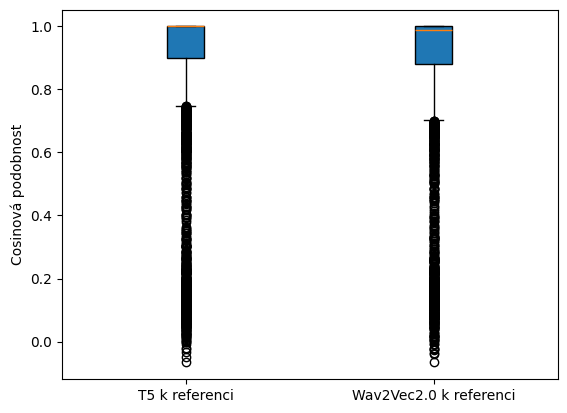

In [6]:
plt.boxplot((semantic_sim["sim_t5_to_ref"], semantic_sim["sim_w2v2_to_ref"]),
            vert=True,
            patch_artist=True,
            labels=["T5 k referenci", "Wav2Vec2.0 k referenci"])
plt.ylabel("Cosinová podobnost")
plt.show()

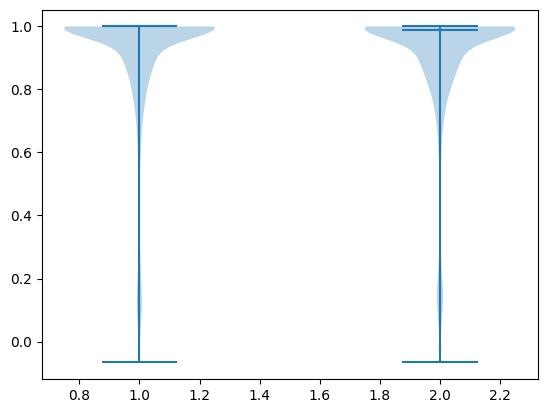

In [7]:
plt.violinplot((semantic_sim["sim_t5_to_ref"], semantic_sim["sim_w2v2_to_ref"]), showmedians=True)
plt.show()

In [ ]:
np.mean(semantic_sim["sim_w2v2_to_ref"])

In [ ]:
np.mean(semantic_sim["sim_t5_to_ref"])

In [ ]:
np.min(semantic_sim["sim_w2v2_to_ref"])

In [ ]:
np.argwhere(np.array(semantic_sim["sim_w2v2_to_ref"]) < 0.2).flatten()

In [ ]:
np.argmin(semantic_sim["sim_w2v2_to_ref"])

In [ ]:
np.std(semantic_sim["sim_w2v2_to_ref"])

In [ ]:
np.argmin(semantic_sim["sim_t5_to_ref"])

In [ ]:
np.std(semantic_sim["sim_t5_to_ref"])

In [ ]:
dataset[441]["asr_transcription"]

In [ ]:
t5_correction_and_results["t5_correction"][441]

In [ ]:
dataset[441]["target_output"]

In [ ]:
idx = 750
w2v2_output=dataset[idx]["asr_transcription"]
t5_output=t5_correction_and_results["t5_correction"][idx]
ref = dataset[idx]["target_output"]

In [ ]:
w2v2_output

In [ ]:
t5_output

In [ ]:
ref

In [ ]:
inputs = bert_tokenizer([t5_output, ref], padding=True, return_tensors="pt").to(device)

In [ ]:
embeddings = bert_model(**inputs)
cls_emb = embeddings.last_hidden_state[:, 0, :]

In [ ]:
cls_emb

In [ ]:
cls_emb

In [ ]:
cosine_sim.forward(cls_emb[0], cls_emb[1])

# Morphodita

In [ ]:
from ufal.morphodita import Morpho, Tagger, TaggedLemmas, TokenRanges, Forms, Analyses

In [ ]:
def encode_entities(text: str):
    return text.replace('&', '&amp;').replace('<', '&lt;').replace('>', '&gt;').replace('"', '&quot;')

In [ ]:
# morpho = Morpho.load("data/czech-morfflex2.0-pdtc1.0-220710/czech-morfflex2.0-220710.dict")
tagger = Tagger.load("data/czech-morfflex2.0-pdtc1.0-220710/czech-morfflex2.0-pdtc1.0-220710.tagger")

In [ ]:
forms = Forms()
lemmas = TaggedLemmas()
tokens = TokenRanges()
# analyses = Analyses()
tokenizer = tagger.newTokenizer()
# tagger.tagAnalyzed()

In [ ]:
line = "r"
tokenizer.setText(line)

t = 0
while tokenizer.nextSentence(forms, tokens):
    tagger.tag(forms, lemmas)
    for i in range(len(lemmas)):
        lemma = lemmas[i]
        token = tokens[i]
        # tagger.tagAnalyzed(token, lemma.lemma, lemma.tag)
        print('%s\t<token lemma="%s" tag="%s">%s</token>%s' % (
        # encode_entities(line[t : token.start]),
        "<sentence>\n" if i == 0 else "",
        encode_entities(lemma.lemma),
        encode_entities(lemma.tag),
        encode_entities(line[token.start : token.start + token.length]),
        "\n</sentence>" if i + 1 == len(lemmas) else "",
        ), sep="\n")
        t = token.start + token.length